In [2]:
!pip install git+https://github.com/scikit-fuzzy/scikit-fuzzy.git

  Cloning https://github.com/scikit-fuzzy/scikit-fuzzy.git to /tmp/pip-req-build-yoe3ug0h
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-fuzzy/scikit-fuzzy.git /tmp/pip-req-build-yoe3ug0h
  Resolved https://github.com/scikit-fuzzy/scikit-fuzzy.git to commit be7e344f3ce65845e39922aa5fc1af7412d01944
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.5.0-py2.py3-none-any.whl size=920820 sha256=ecd31fc50b82117ebf3a11108ced25e7236604601a0812a4e6f3ca6f32dcf4d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-cutoqoe1/wheels/0d/d9/46/a6fc3441ce02df4116e25e0e904345c0ba7f3c621b81ceb677
Successfully built scikit-fuzzy


In [3]:
!pip install fuzzy-c-means

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.2
    Uninstalling typer-0.15.2:
      Successfully uninstalled typer-0.15.2
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.38.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [4]:
from fcmeans import FCM

In [23]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


In [8]:
# making data frame
df = pd.read_csv("/content/heart_disease_uci.csv")
print(df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


In [9]:
# Handle missing values (fill numerical with mean, categorical with mode)
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Encode categorical features
categorical_columns = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
le = LabelEncoder()

for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Convert binary categorical columns to integer
df['fbs'] = df['fbs'].astype(int)
df['exang'] = df['exang'].astype(int)

# Remove outliers using Z-score
df = df[(np.abs(stats.zscore(df.select_dtypes(include=['int64', 'float64']))) < 3).all(axis=1)]

# Normalize numerical features
scaler = StandardScaler()
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Display the cleaned dataset
df.head()

<ipython-input-9-27dfeca02b2f>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.mode().iloc[0], inplace=True)
<ipython-input-9-27dfeca02b2f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_features] = scaler.fit_transform(df[numeric_features])


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,1.023753,1,0,3,0.782463,0.336280,1,0,0.488625,0,1.472118,0,-1.485882,0,0
2,3,1.448735,1,0,0,-0.684341,0.298878,0,0,-0.347860,1,1.775389,1,3.274755,2,1
3,4,-1.738626,1,0,2,-0.097620,0.495238,0,1,1.962431,0,2.685203,0,-1.485882,1,0
4,5,-1.313645,0,0,1,-0.097620,0.065116,0,0,1.364942,0,0.562304,2,-1.485882,1,0
5,6,0.280036,1,0,1,-0.684341,0.364331,0,1,1.603938,0,-0.044238,2,-1.485882,1,0


<ipython-input-10-4a4c9a2ebdea>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.mode().iloc[0], inplace=True)


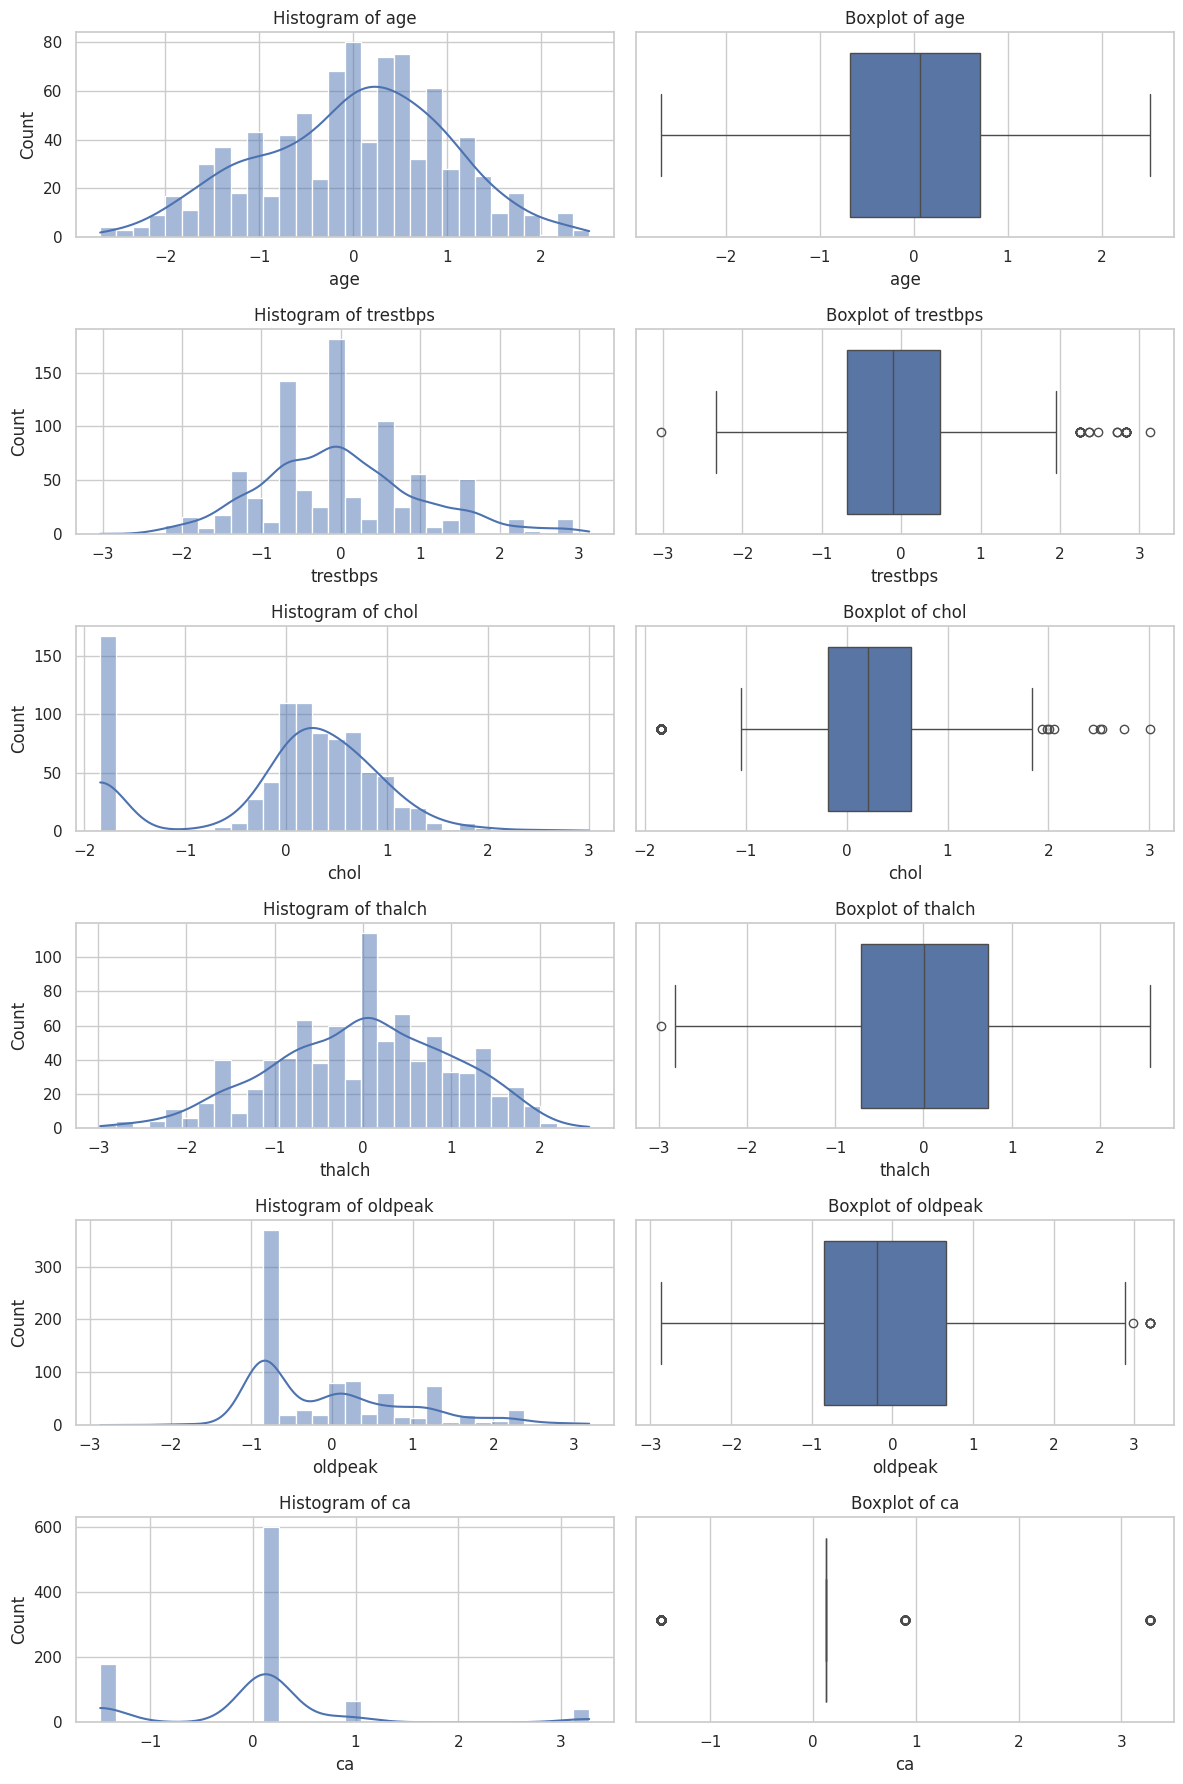

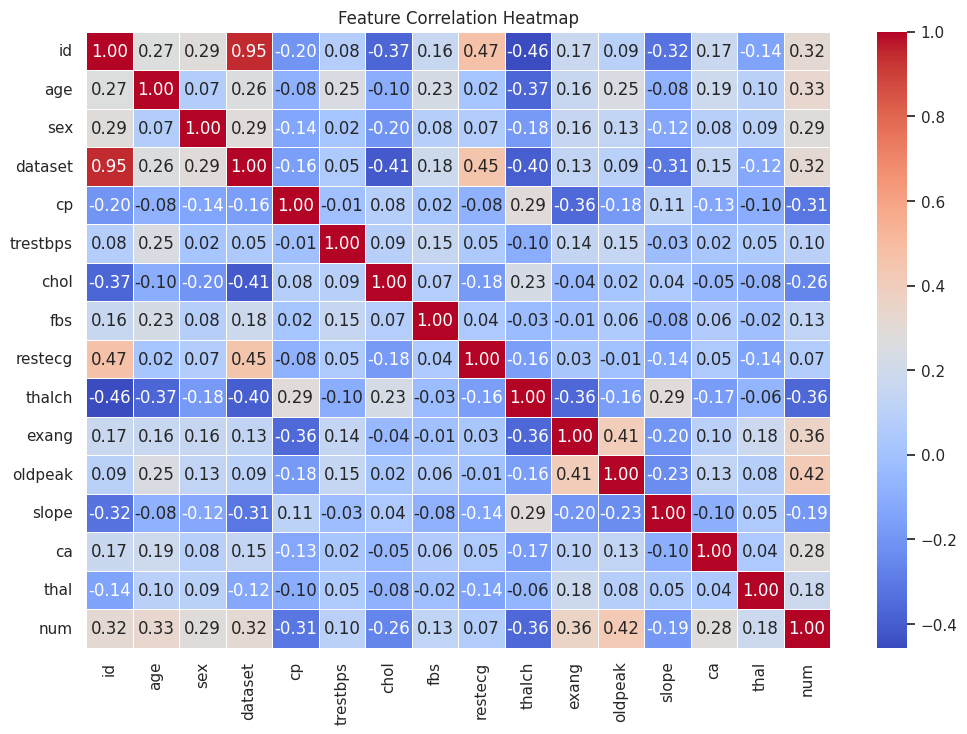

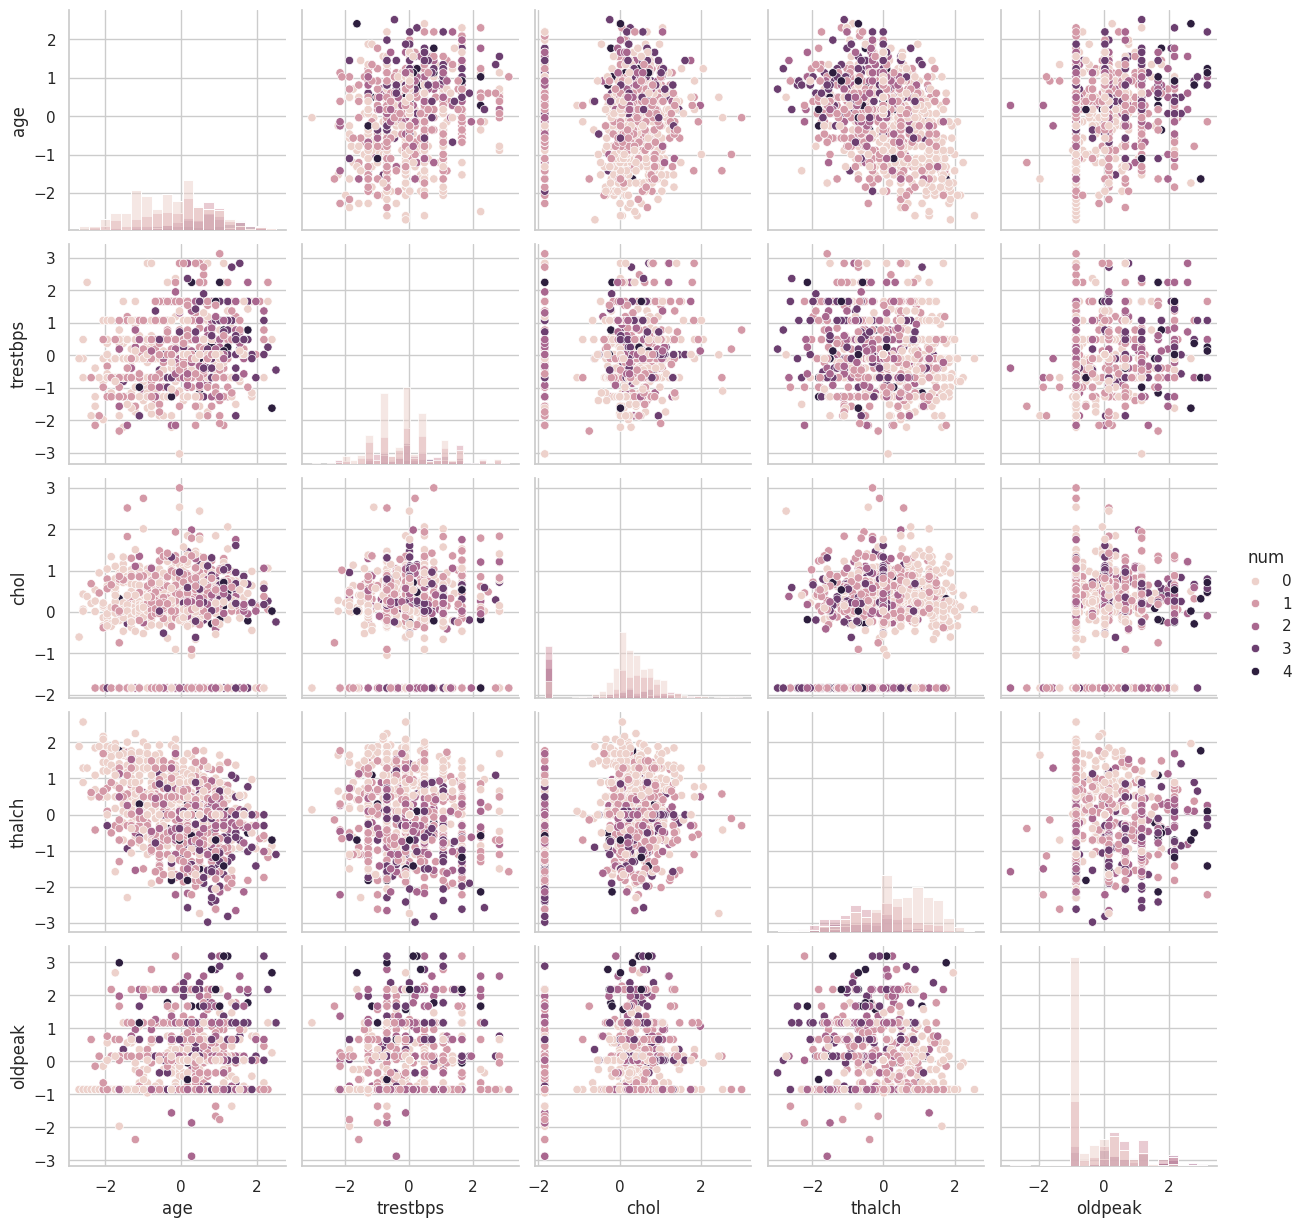

In [10]:
# Set seaborn style
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("heart_disease_uci.csv")

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Encode categorical features
categorical_columns = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Convert binary categorical columns to integer
df['fbs'] = df['fbs'].astype(int)
df['exang'] = df['exang'].astype(int)

# Remove outliers using Z-score
df = df[(np.abs(stats.zscore(df.select_dtypes(include=['int64', 'float64']))) < 3).all(axis=1)]

# Normalize numerical features
scaler = StandardScaler()
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Histograms & Boxplots
fig, axes = plt.subplots(len(numeric_features), 2, figsize=(12, 18))
for i, feature in enumerate(numeric_features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {feature}")

    sns.boxplot(x=df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

#Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

#Pairplots (Selected Features)
df['num'] = df['num'].astype(int)
sns.pairplot(df, hue="num", diag_kind="hist", vars=['age', 'trestbps', 'chol', 'thalch', 'oldpeak'])
plt.show()

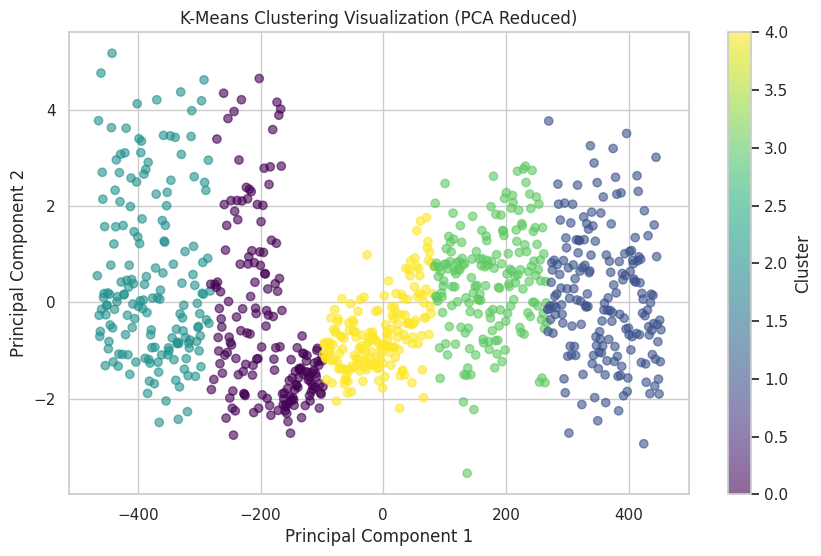

Silhouette Score for K-Means: 0.5636


In [11]:
# Handle missing values (if any) - 'features' should be 'df'
df.fillna(df.mean(numeric_only=True), inplace=True)

# Apply K-Means Clustering - 'features' should be 'df'
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df)

# Reduce dimensions using PCA for visualization - 'features' should be 'df'
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(df)

# Scatter plot of K-Means clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Compute Silhouette Score for K-Means - 'features' should be 'df'
silhouette_kmeans = silhouette_score(df, kmeans_labels)
print(f"Silhouette Score for K-Means: {silhouette_kmeans:.4f}")

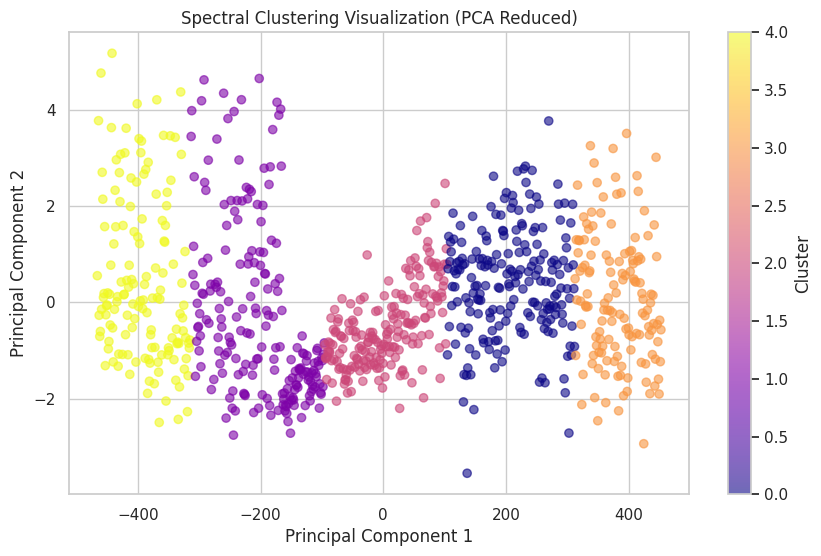

Silhouette Score for Spectral Clustering: 0.5448


In [12]:
# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
spectral_labels = spectral.fit_predict(df)

# Scatter plot of Spectral Clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=spectral_labels, cmap='plasma', alpha=0.6)
plt.title("Spectral Clustering Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Compute Silhouette Score for Spectral Clustering
silhouette_spectral = silhouette_score(df, spectral_labels)
print(f"Silhouette Score for Spectral Clustering: {silhouette_spectral:.4f}")

ERROR: Could not find a version that satisfies the requirement fcmeans (from versions: none)
ERROR: No matching distribution found for fcmeans


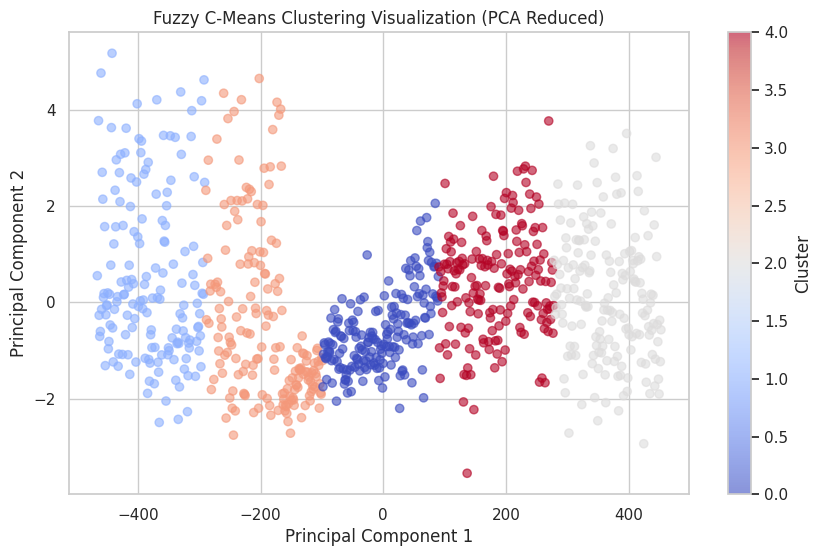

Silhouette Score for Fuzzy C-Means: 0.5618


In [13]:

# Apply Fuzzy C-Means Clustering
fcm = FCM(n_clusters=5, random_state=42)
fcm.fit(df.values) # Changed 'features' to 'df'
fcm_labels = fcm.predict(df.values) # Changed 'features' to 'df'

# Scatter plot of Fuzzy C-Means clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=fcm_labels, cmap='coolwarm', alpha=0.6)
plt.title("Fuzzy C-Means Clustering Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Compute Silhouette Score for Fuzzy C-Means
silhouette_fcm = silhouette_score(df, fcm_labels) # Changed 'features' to 'df'
print(f"Silhouette Score for Fuzzy C-Means: {silhouette_fcm:.4f}")

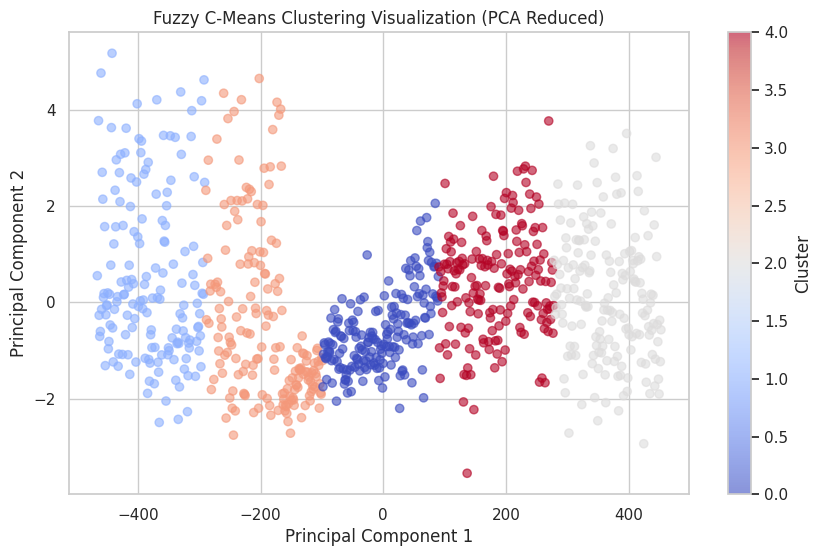

Silhouette Score for Fuzzy C-Means: 0.5618


In [14]:


# Apply Fuzzy C-Means Clustering
fcm = FCM(n_clusters=5, random_state=42)
fcm.fit(df.values) # Changed 'features' to 'df'
fcm_labels = fcm.predict(df.values) # Changed 'features' to 'df'

# Scatter plot of Fuzzy C-Means clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=fcm_labels, cmap='coolwarm', alpha=0.6)
plt.title("Fuzzy C-Means Clustering Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Compute Silhouette Score for Fuzzy C-Means
silhouette_fcm = silhouette_score(df, fcm_labels) # Changed 'features' to 'df'
print(f"Silhouette Score for Fuzzy C-Means: {silhouette_fcm:.4f}")

In [15]:
# Train AdaBoost Classifier
adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)

# Evaluate AdaBoost Model
print("\n📌 AdaBoost Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_adaboost):.4f}")
print(f"   MSE: {mean_squared_error(y_test, y_pred_adaboost):.4f}")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_adaboost):.4f}")


NameError: name 'X_train' is not defined

In [22]:


# Initialize AdaBoost with a Decision Tree as the base estimator
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Weak learner (stump)
    n_estimators=50,  # Number of weak learners
    learning_rate=1.0,  # Learning rate
    random_state=42
)

# Train the model
ada_model.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_model.predict(X_test)

# Evaluate the model
ada_accuracy = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")

AdaBoost Accuracy: 0.6610


In [25]:
sgd = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

# Evaluate SGD Model
print("\n SGD (Gradient Descent) Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_sgd):.4f}")
print(f"   MSE: {mean_squared_error(y_test, y_pred_sgd):.4f}")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_sgd):.4f}")


 SGD (Gradient Descent) Performance:
   Accuracy: 0.3446
   MSE: 1.0621
   MAE: 0.7797


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,  # Maximum depth of each tree
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"Random Forest MAE: {rf_mae:.4f}")

Random Forest Accuracy: 0.6554
Random Forest MSE: 0.9209
Random Forest MAE: 0.5141


In [27]:
from xgboost import XGBClassifier

# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Maximum depth of a tree
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost MSE: {xgb_mse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")

XGBoost Accuracy: 0.6723
XGBoost MSE: 0.8192
XGBoost MAE: 0.4689


In [28]:
from sklearn.svm import SVC

# Initialize SVM
svm_model = SVC(
    kernel='rbf',  # Radial Basis Function kernel
    C=1.0,  # Regularization parameter
    random_state=42
)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_mse = mean_squared_error(y_test, y_pred_svm)
svm_mae = mean_absolute_error(y_test, y_pred_svm)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM MSE: {svm_mse:.4f}")
print(f"SVM MAE: {svm_mae:.4f}")

SVM Accuracy: 0.6271
SVM MSE: 1.0395
SVM MAE: 0.5537


In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,  # Maximum number of iterations
    random_state=42
)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression MSE: {lr_mse:.4f}")
print(f"Logistic Regression MAE: {lr_mae:.4f}")

Logistic Regression Accuracy: 0.6441
Logistic Regression MSE: 0.8757
Logistic Regression MAE: 0.5028


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Comapring All models

In [33]:
import pandas as pd
from sklearn.metrics import accuracy_score

# ... (your existing code for model training and prediction) ...

# Calculate accuracy for SGD model
sgd_accuracy = accuracy_score(y_test, y_pred_sgd)  # Assign value to sgd_accuracy

results = {
    'Model': ['AdaBoost', 'SGDClassifier', 'Random Forest', 'XGBoost', 'SVM', 'Logistic Regression'],
    'Accuracy': [ada_accuracy, sgd_accuracy, rf_accuracy, xgb_accuracy, svm_accuracy, lr_accuracy],
    'MSE': [mean_squared_error(y_test, y_pred_ada), mean_squared_error(y_test, y_pred_sgd),
            rf_mse, xgb_mse, svm_mse, lr_mse],
    'MAE': [mean_absolute_error(y_test, y_pred_ada), mean_absolute_error(y_test, y_pred_sgd),
            rf_mae, xgb_mae, svm_mae, lr_mae]
}

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy       MSE       MAE
0             AdaBoost  0.661017  0.853107  0.491525
1        SGDClassifier  0.344633  1.062147  0.779661
2        Random Forest  0.655367  0.920904  0.514124
3              XGBoost  0.672316  0.819209  0.468927
4                  SVM  0.627119  1.039548  0.553672
5  Logistic Regression  0.644068  0.875706  0.502825


In [40]:
# Ensure all models have made predictions
y_pred_ada = adaboost.predict(X_test)
y_pred_sgd = sgd.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

# ... (rest of your code) ...

# Calculate accuracy for each model
ada_accuracy = accuracy_score(y_test, y_pred_ada)
sgd_accuracy = accuracy_score(y_test, y_pred_sgd)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

# Calculate MSE and MAE
ada_mse = mean_squared_error(y_test, y_pred_ada)
sgd_mse = mean_squared_error(y_test, y_pred_sgd)
rf_mse = mean_squared_error(y_test, y_pred_rf)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
svm_mse = mean_squared_error(y_test, y_pred_svm)
lr_mse = mean_squared_error(y_test, y_pred_lr)

ada_mae = mean_absolute_error(y_test, y_pred_ada)
sgd_mae = mean_absolute_error(y_test, y_pred_sgd)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
svm_mae = mean_absolute_error(y_test, y_pred_svm)
lr_mae = mean_absolute_error(y_test, y_pred_lr)

# Create results dictionary
results = {
    'Model': ['AdaBoost', 'SGDClassifier', 'Random Forest', 'XGBoost', 'SVM', 'Logistic Regression'],
    'Accuracy': [ada_accuracy, sgd_accuracy, rf_accuracy, xgb_accuracy, svm_accuracy, lr_accuracy],
    'MSE': [ada_mse, sgd_mse, rf_mse, xgb_mse, svm_mse, lr_mse],
    'MAE': [ada_mae, sgd_mae, rf_mae, xgb_mae, svm_mae, lr_mae]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)


                 Model  Accuracy       MSE       MAE
0             AdaBoost  0.661017  0.853107  0.491525
1        SGDClassifier  0.344633  1.062147  0.779661
2        Random Forest  0.655367  0.920904  0.514124
3              XGBoost  0.672316  0.819209  0.468927
4                  SVM  0.627119  1.039548  0.553672
5  Logistic Regression  0.644068  0.875706  0.502825
